<a href="https://colab.research.google.com/github/boangri/uai-thesis-notebooks/blob/main/GrandPrix_DQN_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GrandPrix - Deep Q Learning - keras

In [ ]:
!pip install -e git+https://github.com/boangri/gym-grand-prix.git#egg=gym_grand_prix

Obtaining gym_grand_prix from git+https://github.com/boangri/gym-grand-prix.git#egg=gym_grand_prix
  Cloning https://github.com/boangri/gym-grand-prix.git to ./src/gym-grand-prix
  Running command git clone -q https://github.com/boangri/gym-grand-prix.git /content/src/gym-grand-prix
     |████████████████████████████████| 11.5MB 8.7MB/s 
  Running setup.py develop for gym-grand-prix


In [ ]:
import gym_grand_prix

GrandPrix-v0 version 0.0.8 31.10.2020


## Agent

In [ ]:
%tensorflow_version 1.x

from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import numpy as np

class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        # store one hot encoding of actions, if appropriate
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    model = Sequential([
                Dense(fc1_dims, input_shape=(input_dims,)),
                Activation('relu'),
                Dense(fc2_dims),
                Activation('relu'),
                Dense(n_actions)])

    model.compile(optimizer=Adam(lr=lr), loss='mse')

    return model

class Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
                 input_dims, epsilon_dec=0.996,  epsilon_end=0.01,
                 mem_size=1000000, fname='dqn_model.h5'):
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions,
                                   discrete=True)
        self.q_eval = build_dqn(alpha, n_actions, input_dims, 512, 128)
        self.norm = np.array((1., 1.)+(0.25,)*n_rays)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, state):
        state = state[np.newaxis, :]
        # state *= self.norm
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)

        return action

    def learn(self):
        if self.memory.mem_cntr > self.batch_size:
            state, action, reward, new_state, done = \
                                          self.memory.sample_buffer(self.batch_size)

            action_values = np.array(self.action_space, dtype=np.int8)
            action_indices = np.dot(action, action_values)

            q_eval = self.q_eval.predict(state)

            q_next = self.q_eval.predict(new_state)

            q_target = q_eval.copy()

            batch_index = np.arange(self.batch_size, dtype=np.int32)

            q_target[batch_index, action_indices] = reward + \
                                  self.gamma*np.max(q_next, axis=1)*done

            _ = self.q_eval.fit(state, q_target, verbose=0)

            self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > \
                           self.epsilon_min else self.epsilon_min

    def save_model(self):
        self.q_eval.save(self.model_file)

    def load_model(self):
        self.q_eval = load_model(self.model_file)

TensorFlow 1.x selected.


Using TensorFlow backend.


## Обучение

In [ ]:
import gym
import gym_grand_prix

import numpy as np
import random

from time import time
import matplotlib.pyplot as plt

def plot(score_history, filename='learning.png', title='Training'):
    x = [i+1 for i in range(len(score_history))]
    avg_score = []
    for i in range(len(score_history)):
        avg_score.append(np.mean(score_history[i-100:i])) 

    fig = plt.figure(figsize=(12, 6))
    plt.scatter(x, score_history, label='score')
    plt.plot(x, avg_score, color='C1', label='avg_score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()
    fig.savefig(filename)

def plotLearning(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)


In [ ]:
n_rays = 5
GAMMA = 0.95
fc1 = 512
fc2 = 128
ind = int((n_rays + 3)/2) # Индекс луча, смотрящего вперед (расстояние до стенки)

lr = 0.0005
agent = Agent(gamma=GAMMA, epsilon=1., epsilon_dec=0.999, alpha=lr, input_dims=7,
                n_actions=5, mem_size=1000000, batch_size=200, epsilon_end=0.0)

resume_learn = False
render = False
if resume_learn:
    agent.load_weights()
    print("Loaded model weights")

score_history = []
collision_history = []
running_score = 0.
running_collisions = 0.
record_score = 0.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


pygame 2.0.0 (SDL 2.0.12, python 3.6.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0 score: -6.343  avg score -6.343  eps 1.0000  col 6 avg_col 6.000

1 score: -9.043  avg score -7.693  eps 0.9990  col 7 avg_col 6.500
2 score: -14.287  avg score -9.891  eps 0.9980  col 13 avg_col 8.667
3 score: -8.951  avg score -9.656  eps 0.9970  col 8 avg_col 8.500
4 score: -8.252  avg score -9.375  eps 0.9960  col 7 avg_col 8.200
5 score: -6.245  avg score -8.853  eps 0.9950  col 5 avg_col 7.667
6 score: -11.995  avg score -9.302  eps 0.9940  col 11 avg_col 8.143
7 score: -10.975  avg score -9.511  eps 0.9930  col 10 avg_col 8.375
8 score: -6.265  avg score -9.151  eps 0.9920  col 3 avg_col 7.778
9 score: -5.800  avg score -8.816  eps 0.9910  col 4 avg_col 7.400
10 score: -5.235  avg score -8.490  eps 0.9900  col 4 avg_col 7.091
11 score: -7.726  avg score -8.426  eps 0.9891  col 6 avg_col 7.000
12 score: -1.913  avg score -7.925  eps 0.9881  col 2 avg_col 6.615
13 score: -8.121  avg score -7.939  eps 0.9871  col 6 avg_col 6.571
14 score: -3.072  avg score -7.615  eps 0.9861  col

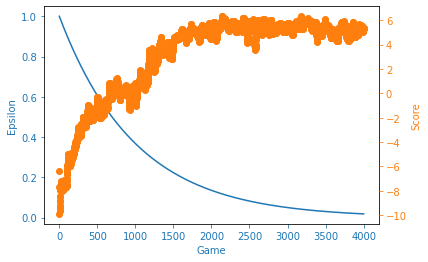

In [ ]:
ep0 = 0 # номер начального эпизода (для обучения в несколько этапов)
n_episodes = 4000
n_steps = 200 # число шагов в эпизоде
fname = "%dx%d_ep%dg%2d" % (fc1, fc2, n_episodes, int(GAMMA*100))
possible_actions = ((0, 0), (1, .75), (-1, .75), (0, .75), (0, -.75))
random.seed(ep0+12345)
track = 3
env = gym.make('GrandPrix-v0')
options = {
    'nrays': n_rays,
    'seed': track, # задает номер трека
}
if render:
    options['display'] = 1
    env.setOptions(options)
eps_history = []
possible_actions = ((0, 0), (1, .75), (-1, .75), (0, .75), (0, -.75))

cur_time = time()
for i in range(ep0, n_episodes):
    done = False
    score = 0
    collisions = 0
    observation = env.reset()
    for step in range(n_steps):
        if render:
            env.render()
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(possible_actions[action])
        done = (step == (n_steps - 1))
        if 'collision' in info and info['collision']:
            collisions += 1
            reward -= 200.
        score += reward
        agent.remember(observation, action, reward, observation_, int(done))
        observation = observation_
    
    agent.learn()
    eps_history.append(agent.epsilon)
    score /= n_steps
    score_history.append(score)
    collision_history.append(collisions)
    beta = 1/(1 + min(99, i))
    running_collisions = (1 - beta)*running_collisions + beta*collisions
    avg_score = np.mean(score_history[max(0, i-100):(i+1)])
    print(i,'score: %.3f' % score,
            ' avg score %.3f' % avg_score, ' eps %.4f' % agent.epsilon, ' col %d' % collisions, 'avg_col %.3f' % running_collisions)

    if i % 100 == 0 and i > 0:
        agent.save_model()
print("It took %.1f secs" % (time() - cur_time))
filename = 'grandprix.png'

x = [i+1 for i in range(n_episodes)]
plotLearning(x, score_history, eps_history, filename)

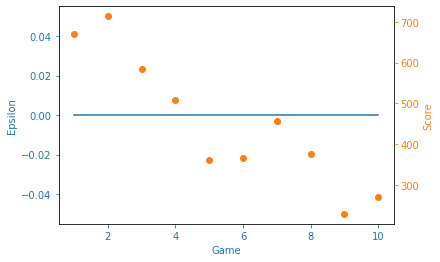

In [ ]:
x = [i+1 for i in range(n_episodes)]
plotLearning(x, scores, eps_history, filename)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


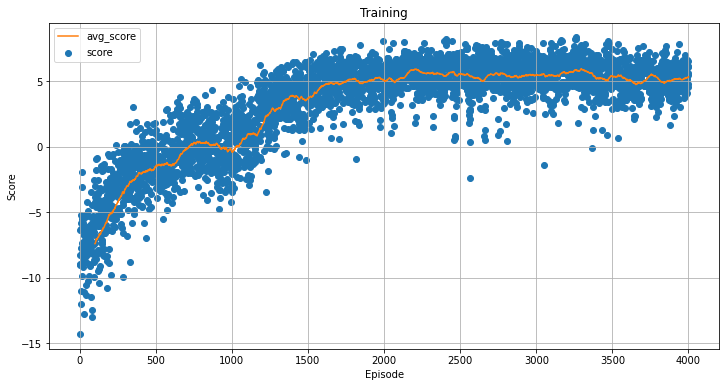

In [ ]:
plot(score_history)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


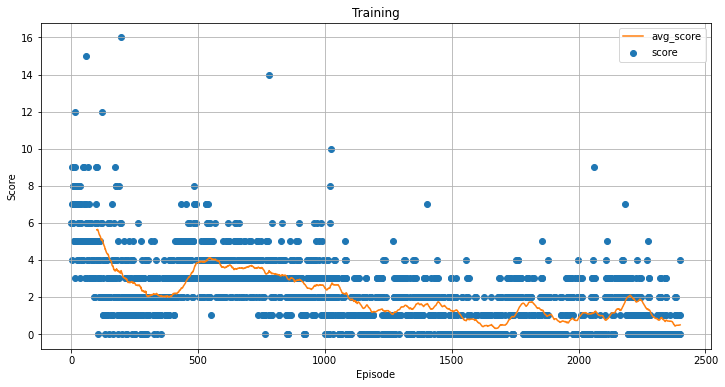

In [ ]:
plot(collision_history)